In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymannkendall as mk
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

### Bring in data

In [2]:
df_filled = pd.read_csv('data/missoula_valley_wells_imputed_qreg.csv')
df_pump = pd.read_csv('data/mso_monthly_pumping_rates.csv')
df_static = pd.read_csv('data/static_variables.csv')

# Clip data to full water years for all wells
df_filled = df_filled[(df_filled['time'] >= '1999-10-01') & (df_filled['time'] <= '2023-09-30')]

q = df_filled[['time','Q']]
q.set_index('time', inplace=True)
q.index = pd.to_datetime(q.index)

### Seasonal decomposition with LOESS

In [3]:
stl = STL(q, seasonal=13, robust=True)
res = stl.fit()

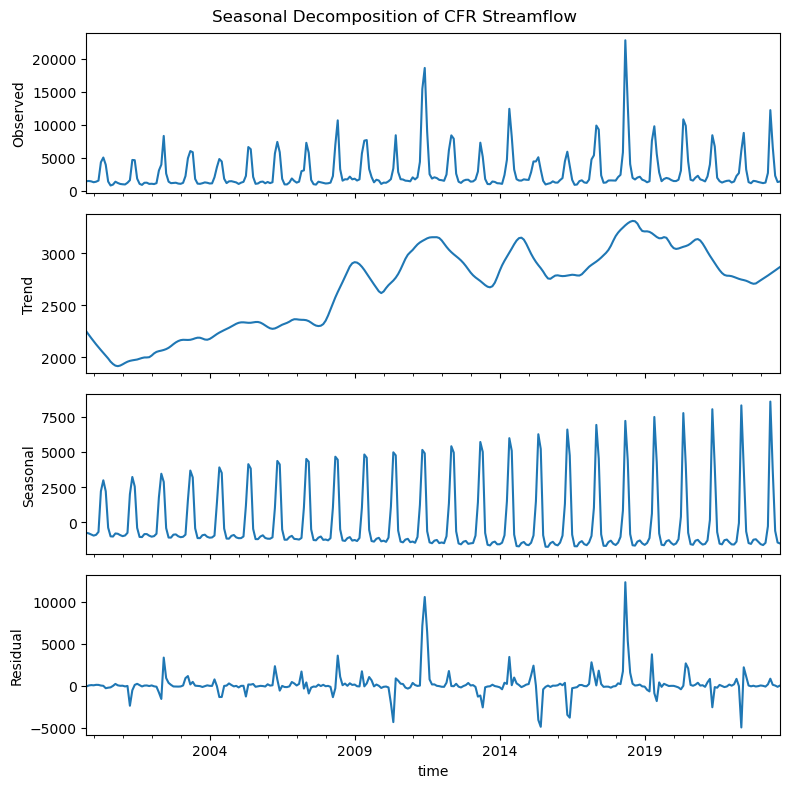

In [4]:
fig, ax = plt.subplots(4, 1, figsize=(8, 8), sharex=True)
res.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Observed')
res.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Trend')
res.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('Seasonal')
res.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel('Residual')
fig.tight_layout()
fig.suptitle('Seasonal Decomposition of CFR Streamflow')
fig.subplots_adjust(top=0.95)
plt.show()



### Trend analysis

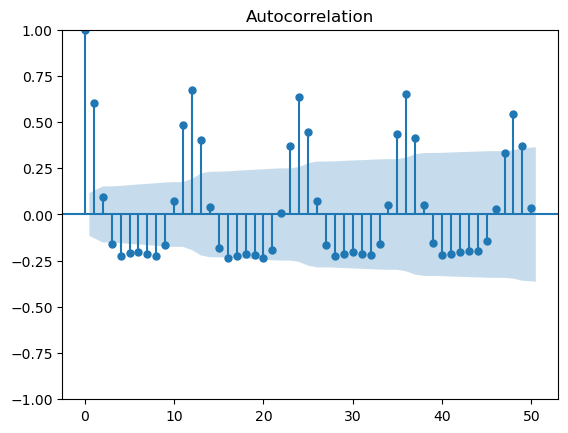

In [5]:
sm.graphics.tsa.plot_acf(q, lags=50)
plt.show()

In [6]:
# There is strong seasonal autocorrelation so we use the seasonal Mann-Kendall test. 
# This test looks for trends across the seasons, rather than across the entire time series.
# This test assumes that the trends across seasons are in the same direction, otherwise 
# the test may not be valid. 
mk_full = mk.seasonal_test(q, period=12)
print(f"The trend in the full timeseries is {mk_full.slope:.3f} (cfs/mo) with a p-value of {mk_full.p:.3f}")


The trend in the full timeseries is 24.000 (cfs/mo) with a p-value of 0.000


In [7]:
# In case the trends are not consistent across seasons, we can look at the trends in the
# decomposed trend component.
mk_full_t = mk.original_test(res.trend)
print(f"The trend in the full timeseries is {mk_full_t.slope:.3f} (cfs/mo) with a p-value of {mk_full_t.p:.3e}")

The trend in the full timeseries is 4.261 (cfs/mo) with a p-value of 0.000e+00


### Seasonal trend analysis

In [68]:
q = q.assign(season = q.index.month.map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer', 
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}))

q_seas = q.groupby('season').resample('Y')['Q'].mean().reset_index(['season'])
q_seas.index = q_seas.index.strftime('%Y')

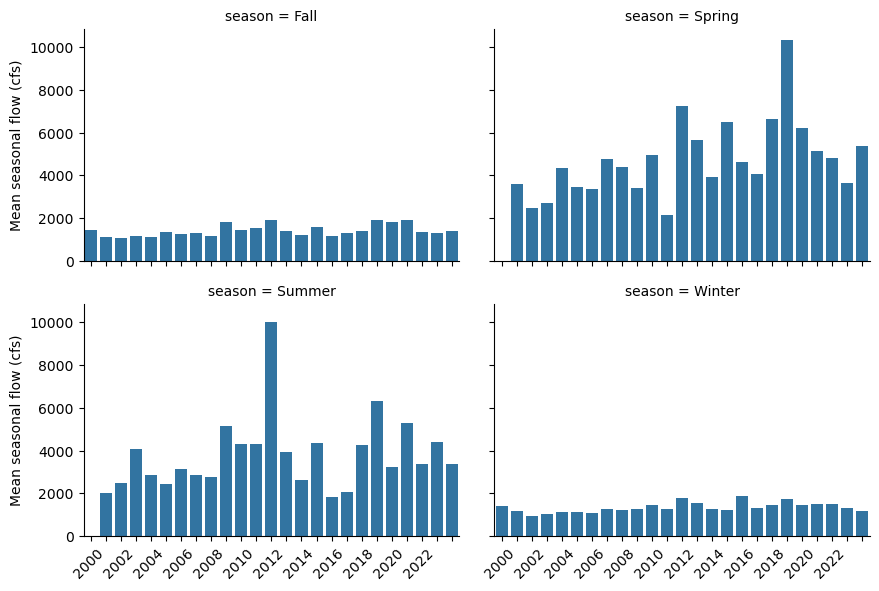

In [72]:
# Create the FacetGrid plot
g = sns.FacetGrid(q_seas.reset_index(), col='season', col_wrap=2, sharey=True, sharex=True, height=3, aspect=1.5)
g.map(sns.barplot, 'time','Q', order=q_seas.index.unique())
g.set_ylabels('Mean seasonal flow (cfs)')

# Rotate the x-tick labels on all subplots
for ax in g.axes.flat:
    ax.set_xlabel('')
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')
    for label in ax.get_xticklabels()[::2]:
        label.set_visible(False)

plt.show()

In [10]:
# Look for trends in seasons
mk_seas_w = mk.original_test(q_seas['Q'].where(q_seas['season'] == 'Winter').dropna())
mk_seas_sp = mk.original_test(q_seas['Q'].where(q_seas['season'] == 'Spring').dropna())
mk_seas_su = mk.original_test(q_seas['Q'].where(q_seas['season'] == 'Summer').dropna())
mk_seas_f = mk.original_test(q_seas['Q'].where(q_seas['season'] == 'Fall').dropna())

print(f"The trend in Winter timeseries is {mk_seas_w.slope:.3f} (cfs/mo) with a p-value of {mk_seas_w.p:.3e}")
print(f"The trend in Spring timeseries is {mk_seas_sp.slope:.3f} (cfs/mo) with a p-value of {mk_seas_sp.p:.3e}")
print(f"The trend in Summer timeseries is {mk_seas_su.slope:.3f} (cfs/mo) with a p-value of {mk_seas_su.p:.3e}")
print(f"The trend in Fall timeseries is {mk_seas_f.slope:.3f} (cfs/mo) with a p-value of {mk_seas_f.p:.3e}")

The trend in Winter timeseries is 16.815 (cfs/mo) with a p-value of 5.449e-03
The trend in Spring timeseries is 113.555 (cfs/mo) with a p-value of 7.953e-03
The trend in Summer timeseries is 48.855 (cfs/mo) with a p-value of 8.699e-02
The trend in Fall timeseries is 13.069 (cfs/mo) with a p-value of 2.651e-02


### Annual max trend analysis

In [42]:
# Calculate the water year for each observation
q['w_year'] = (q.reset_index().time.dt.to_period('A-Sep') - 1).map(str).astype(int).values

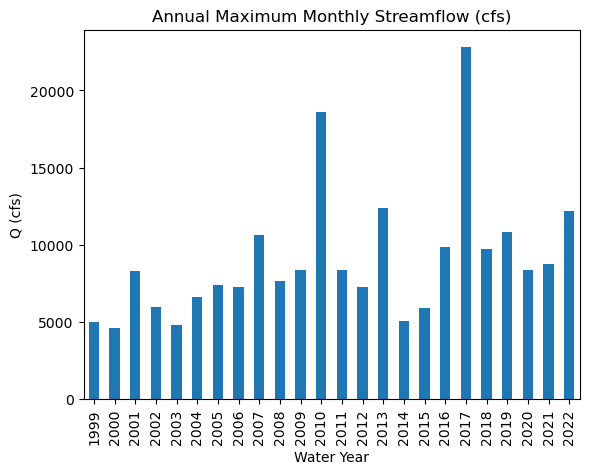

In [50]:
q.loc[:, 'month'] = q.reset_index().time.dt.month.values
q.loc[:, 'month'] = q.loc[:, 'month'].astype(int)
q_max = q.loc[q.groupby('w_year')['Q'].idxmax()]
q_max = q_max.reset_index().set_index('w_year')
q_max['Q'].plot(kind='bar')
plt.title('Annual Maximum Monthly Streamflow (cfs)')
plt.xlabel('Water Year')
plt.ylabel('Q (cfs)')
plt.show()

In [51]:
mk_qmax = mk.original_test(q_max['Q'])
print(f"The trend in annual max flow is {mk_qmax.slope:.3f} (cfs/yr) with a p-value of {mk_qmax.p:.3e}")

The trend in annual max flow is 257.429 (cfs/yr) with a p-value of 2.093e-03


### Total annual average trend

Text(0.5, 1.0, 'Annual Total Streamflow (cfs)')

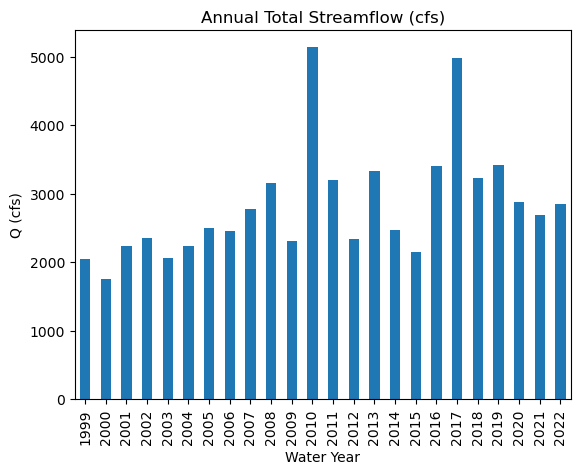

In [52]:
q_avg = q.groupby('w_year')['Q'].mean()
q_avg.plot(kind='bar')
plt.xlabel('Water Year')
plt.ylabel('Q (cfs)')
plt.title('Annual Total Streamflow (cfs)')

In [53]:
mk_qavg = mk.original_test(q_avg)
print(f"The trend in total annual flow is {mk_qavg.slope:.3f} (cfs/yr) with a p-value of {mk_qavg.p:.3e}")

The trend in total annual flow is 47.244 (cfs/yr) with a p-value of 1.632e-03
